In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.metrics  import mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve


**Data Preprocessing**

In [13]:
df_train = pd.read_csv('loan-train.csv')
# drop all rows that contain missing value in Credit_History column
df_train = df_train.dropna(subset=['Credit_History'])

# Fill categorical with mode
df_train['Gender'] = df_train['Gender'].fillna(df_train['Gender'].mode()[0])
df_train['Married'] = df_train['Married'].fillna(df_train['Married'].mode()[0])
df_train['Dependents'] = df_train['Dependents'].fillna(df_train['Dependents'].mode()[0])
df_train['Self_Employed'] = df_train['Self_Employed'].fillna(df_train['Self_Employed'].mode()[0])

# Fill numerical with mean (assign back)
df_train['LoanAmount'] = df_train['LoanAmount'].fillna(df_train['LoanAmount'].mean())
df_train['Loan_Amount_Term'] = df_train['Loan_Amount_Term'].fillna(df_train['Loan_Amount_Term'].mean())

# drop Loan_ID as it is not useful for prediction
df_train = df_train.drop(columns=['Loan_ID'])

# Encode the target variable (Loan_Status: Y -> 1, N -> 0)
# This is needed for the model to work with binary classification
df_train['Loan_Status'] = df_train['Loan_Status'].map({'Y': 1, 'N': 0})
print("Loan_Status encoded: Y=1, N=0")
print(df_train['Loan_Status'].value_counts())

# Define categorical and numerical columns
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

print("Preprocessing pipeline created!")
print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

X = df_train.drop('Loan_Status', axis=1)
y = df_train['Loan_Status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)



Loan_Status encoded: Y=1, N=0
Loan_Status
1    385
0    179
Name: count, dtype: int64
Preprocessing pipeline created!
Categorical features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
Numerical features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [14]:
print(X_train)

    Gender Married Dependents  ... Loan_Amount_Term Credit_History  Property_Area
153   Male     Yes          2  ...            360.0            1.0          Rural
326   Male      No          0  ...            360.0            0.0          Rural
459   Male     Yes          0  ...            360.0            1.0      Semiurban
508   Male     Yes          0  ...            360.0            1.0          Urban
20    Male     Yes          0  ...            360.0            0.0          Urban
..     ...     ...        ...  ...              ...            ...            ...
75    Male      No          0  ...            480.0            1.0          Urban
114   Male      No          0  ...            360.0            1.0      Semiurban
292   Male     Yes          2  ...            360.0            1.0          Urban
472   Male     Yes         3+  ...            360.0            1.0      Semiurban
110   Male      No          0  ...            360.0            1.0          Urban

[394 rows x 11 

In [21]:
from sklearn.tree import DecisionTreeClassifier
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_split=10, min_samples_leaf=5, class_weight='balanced'))
])


In [22]:
dt_pipeline.fit(X_train, y_train)
print("Decision Tree model trained successfully!")

Decision Tree model trained successfully!



--- Model Performance ---
Accuracy: 0.8529
Precision: 0.8273
Recall: 0.9914
ROC-AUC Score: 0.7597

Confusion Matrix:
[[ 30  24]
 [  1 115]]


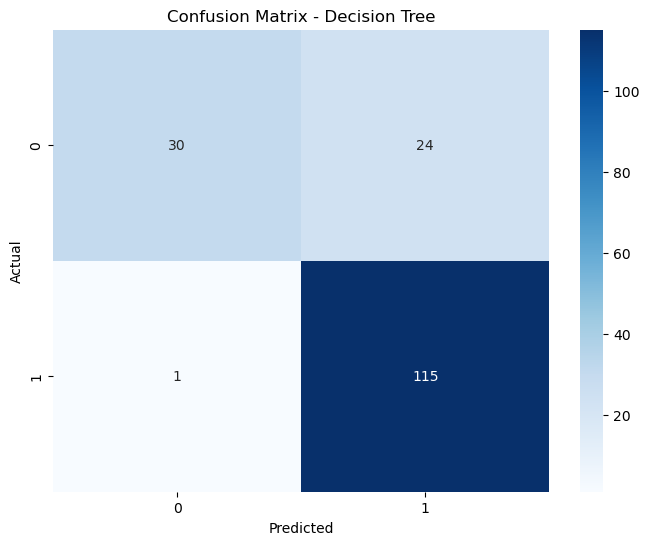

In [23]:

# Make predictions on validation set
y_pred = dt_pipeline.predict(X_val)
y_pred_proba = dt_pipeline.predict_proba(X_val)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print("\n--- Model Performance ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()